# Latent Space as a similarity index

In [1]:
import numpy as np
import scipy as sp

from keras.models import Model
from keras.utils import to_categorical

from plots import plot_vox, plot_dots, plot_compare_recons, plot_recons
from data import load_data, load_custom_model

(x_train, y_train), (x_test, y_test), target_names = load_data('./ModelNet40/')
y_test = to_categorical(y_test)
y_train = to_categorical(y_train)

eval_model = load_custom_model('./models/eval_model_net40_acc_08047.hdf5')
manipulate_model = load_custom_model('./models/manipulate_model_net40_acc_08047.hdf5')

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


Instructions for updating:
dim is deprecated, use axis instead


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/models.py:255: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [2]:
latent_model = Model(eval_model.input, eval_model.layers[-3].output)
# latent_space = latent_model.predict(x_test)
# np.save('latent_space_matrices/latent_space_modelnet40.npy', latent_space)
latent_space = np.load('latent_space_matrices/latent_space_modelnet40.npy')

# Mean Average Precision ModelNet40

In [4]:
from utils import class_subset, query_latent_space, average_precision
from plots import quick_plot

%matplotlib inline

average_precisions = np.zeros(x_test.shape[0])
for i in range(x_test.shape[0]):
    if i % 100 == 0:
        print(i)
    num = i
    num_retrievable = (np.argmax(y_test[num]) == \
                           np.argmax(y_test, axis=1)).sum()
    latent_object = latent_model.predict(x_test[num:num+1])
    sims, latent_indices = query_latent_space(latent_object,
                                        latent_space,
                                        x_test.shape[0])
    ranked_relevant = np.argmax(y_test[num]) ==\
                        np.argmax(y_test[latent_indices], axis=1)

    average_precisions[i] = average_precision(ranked_relevant, num_retrievable)

Text(0.5,1,'Mean Average Precision')

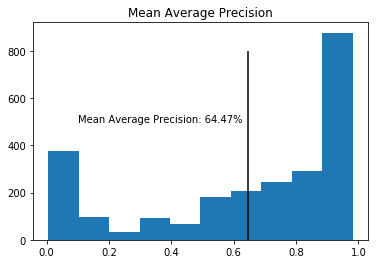

In [114]:
import matplotlib.pyplot as plt
%matplotlib inline

mean_avg_precision = np.mean(average_precisions).astype(float)

plt.hist(average_precisions, bins=10);
plt.text(.1, 500,
         'Mean Average Precision: {:.2%}'.format(mean_avg_precision))
plt.vlines(mean_avg_precision, 0, 800)
plt.title('Mean Average Precision')


# Let's take a look at some samples and see how they're similar

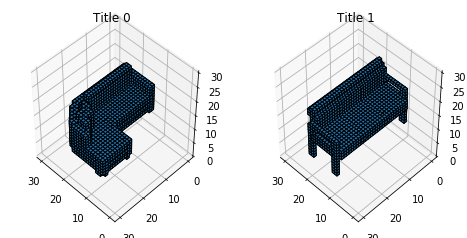

Left: sofa		Right: sofa
Cosine Similarity via Mask Layer: 0.9138912558555603


In [10]:
num1 = 100
num2 = 101
plot_vox(x_test[num1], x_test[num2])
a = latent_space[num1]
b = latent_space[num2]
print('Left: {}\t\tRight: {}'.format(target_names[np.argmax(y_test[num1])], target_names[np.argmax(y_test[num2])]))
print('Cosine Similarity via Mask Layer: {}'.format(1 - sp.spatial.distance.cosine(a, b)))

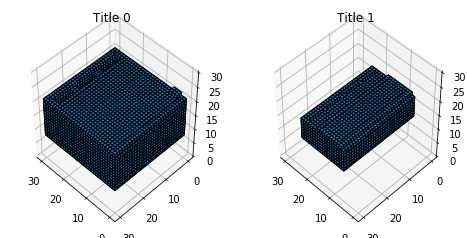

Left: glass_box		Right: glass_box
Cosine Similarity via Mask Layer: 0.36631447076797485


In [47]:
num1 = 20
num2 = 45
plot_vox(x_test[num1], x_test[num2])
a = latent_space[num1]
b = latent_space[num2]
print('Left: {}\t\tRight: {}'.format(target_names[np.argmax(y_test[num1])], target_names[np.argmax(y_test[num2])]))
print('Cosine Similarity via Mask Layer: {}'.format(1 - sp.spatial.distance.cosine(a, b)))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/collections.py:853: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


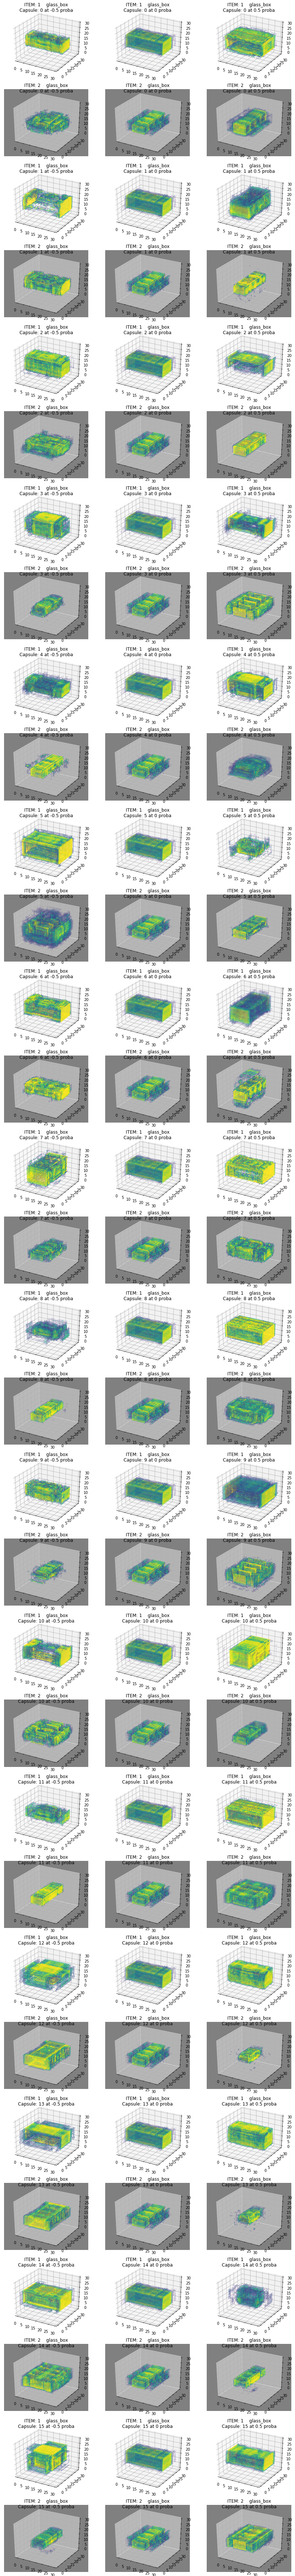

In [48]:
plot_compare_recons(x_test[num1], x_test[num2], y_test[num1], y_test[num2],
                    dim_sub_capsule=16, manipulate_model=manipulate_model,
                    proba_range=[-0.5, 0, 0.5], dotsize_scale=10, dotsize_offset=1,
                    target_names=target_names)

# Stuff

### look at similar beds!

In [21]:
target_names[20:25]

['radio', 'xbox', 'laptop', 'bed', 'curtain']

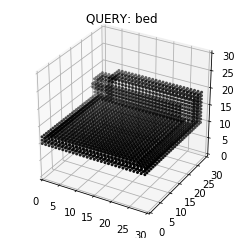

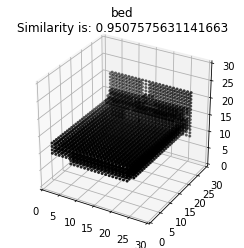

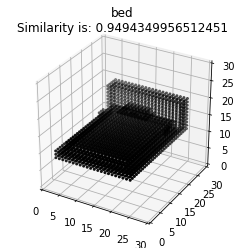

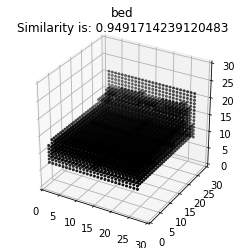

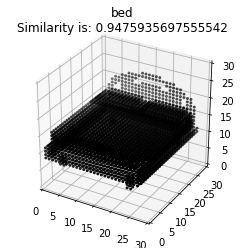

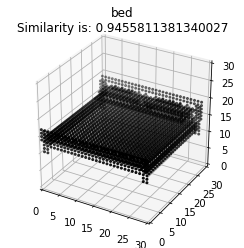

In [23]:
num = 4
query_size = 5
x, y, original_indices = class_subset(x_test, y_test,
                                      'bed', target_names)
latent_object = latent_model.predict(x[num:num+1])
sims, latent_indices = query_latent_space(latent_object, latent_space,
                                    query_size)

name = target_names[np.argmax(y[num])]
quick_plot(x[num], 'QUERY: {}'.format(name))

for sim, relevant_object, y_class in zip(sims,
                                         x_test[latent_indices],
                                         y_test[latent_indices]):
    class_name = target_names[np.argmax(y_class)]
    quick_plot(relevant_object,
               "{}\nSimilarity is: {}".format(class_name,sim))